**Tutorial for gravitational-wave surrogate models**

Nikolaos Stergioulas, Paraskevi Nousi

Aristotle University of Thessaloniki


###### Content provided under a Creative Commons Attribution license, [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/); code under [GNU GPLv3 License](https://choosealicense.com/licenses/gpl-3.0/). (c)2023 [Nikolaos Stergioulas](http://www.astro.auth.gr/~niksterg/), [Paraskevi Nousi](https://www.researchgate.net/profile/Paraskevi-Nousi)

In [1]:
# -- For google colab
! pip install -q pycbc 
! pip install -q forked-rompy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━

In [2]:
from pycbc.waveform import get_td_waveform
import tqdm
import sys 
import numpy as np
import matplotlib.pyplot as plt
import rompy as rp
from scipy.interpolate import PchipInterpolator
from scipy import optimize

In [3]:
plt.rcParams["figure.figsize"] = (10,3)

In [4]:
# auxiliary functions
def Mq_to_m1m2(M, q):
  """Convert total mass, mass ratio pair to m1, m2"""
  m2 = M/(1.+q)
  m1 = M-m2
  return m1, m2

def common_time_grid(training_data, dt):
    """
    INPUT
    =====
    training_data: set of training waveforms

    OUTPUT
    ======
    training data as a numpy array, padding with zeros as
    necessary such that all waveforms are of the same length"""

    longest_waveform = 0
    for h in training_data:
        length = len(h)
        if length > longest_waveform:
            longest_waveform = length

    # print("longest waveform size = %i" % longest_waveform)

    padded_training_data = []
    for h in training_data:
        nZeros = longest_waveform - len(h)
        h_pad = np.append(h, np.zeros(nZeros))
        padded_training_data.append(h_pad)

    times = np.arange(longest_waveform) * dt

    padded_training_data = np.vstack(padded_training_data).transpose()

    return times, padded_training_data

def get_peak(t, h):
    """Get argument and values of t and h at maximum value of |h| on a discrete grid. """
    arg = np.argmax(np.abs(h))
    return [arg, t[arg], h[arg]]

def get_peaks(times, training_set):
    """ Find the index of each waveform's peak in the entire training set. """
    time_peak_arg = []
    for i in range(training_set.shape[1]):
        [arg, t_peak, h_peak] = get_peak(times, training_set[:, i])  # i^th training sample
        time_peak_arg.append(arg)
        # print("Waveform %i with t_peak = %f" % (i, t_peak))
    print(time_peak_arg)
    return time_peak_arg

def align_peaks(times, training_set, dt):
    """ Peak align a set of waveforms. The shortest waveform is used as the reference
    one."""

    time_peak_arg = get_peaks(times, training_set)

    min_peak_time = min(time_peak_arg)
    aligned_training_set = []
    for i in range(training_set.shape[1]):
        offset = time_peak_arg[i] - min_peak_time
        # print("offset value of %i" % offset)
        h_aligned = training_set[offset:, i]
        aligned_training_set.append(h_aligned)

    t, training_data_aligned = common_time_grid(aligned_training_set, dt=dt)
    return min_peak_time, training_data_aligned

In [5]:
def align_A_phi(times, training_A, training_phi, dt):
    """ Peak align a set of waveforms. The shortest waveform is used as the reference
    one."""

    time_peak_arg = get_peaks(times, training_A)

    min_peak_time = min(time_peak_arg)
    aligned_training_A = []
    aligned_training_phi = []

    for i in range(training_A.shape[1]):
        offset = time_peak_arg[i] - min_peak_time
        A_aligned = training_A[offset:, i]
        phi_aligned = training_phi[offset:, i]
        aligned_training_A.append(A_aligned)
        aligned_training_phi.append(phi_aligned)

    t, training_A_aligned = common_time_grid(aligned_training_A, dt=dt)
    t, training_phi_aligned = common_time_grid(aligned_training_phi, dt=dt)
    return min_peak_time, training_A_aligned, training_phi_aligned

In [6]:
def training_set_generator(Mtot=60, nsample=20, q_min=1.0, q_max=8.0, s1=0.0,
                           s2=0.0, f_low=8.0, delta_t=1/2048, 
                           amplitude_scaling=1e18, sampling='random', 
                           verbose=False):

  if sampling == 'linear':
    lambda_values = np.linspace(q_min, q_max, nsample)
    lambda_values_sorted = lambda_values
  elif sampling == 'random':
    lambda_values = np.random.uniform(low=q_min, high=q_max, size=nsample)
    lambda_values_sorted = np.sort(lambda_values)

  training_hp = []
  training_hc = []

  for (q) in tqdm.tqdm(lambda_values_sorted):
    m1, m2 = Mq_to_m1m2(Mtot, q)
    hp, hc = get_td_waveform(approximant='SEOBNRv4',
                             mass1=m1,
                             mass2=m2,
                             spin1z=s1,
                             spin2z=s2,
                             delta_t=delta_t,
                             f_lower=f_low,
                             mode_array=[[2, 2]])
    
    hp = amplitude_scaling*hp
    hc = amplitude_scaling*hc

    training_hp.append(hp)
    training_hc.append(hc)

    if verbose:
      print('length of h is', len(hp))
  return lambda_values_sorted, training_hp, training_hc

###Constants and units. We use a dimensionless system of units defined by setting $c=G=M_\odot=1$.

In [7]:
G = 6.67408e-11
c = 2.99792458e8
MSUN = 1.9891e30

#Time unit
TIME = G*MSUN/c**3

###REDUCED ORDER MODEL

Construct a template bank of waveforms with total mass $M_{\rm tot}$. 

In [8]:
Mtot = 60

delta_t_init = 1.0/4096

print('delta_t =',delta_t_init)

delta_t = 0.000244140625


Choose the number of training samples, the range for $q, s_1, s_2$, the starting frequency $f_{\rm lower}$ and an amplitude scaling so that the maximum amplitude is of order unity. Generate the training set. The outpout for each polarization is a row-ordered matrix (each row is one waveform in Pycbc format). 

In [9]:
nsample = 40
q_min = 1.0
q_max = 8.0
spin1z = 0.0 # nonspinning in this example
spin2z = 0.0 # nonspinning in this example
f_lower = 8.0
amplitude_scaling = 1e18

lambda_values, hp_ro_pycbc, hc_ro_pycbc = training_set_generator(Mtot, nsample, \
                                                  q_min, q_max, spin1z, spin2z, f_lower, delta_t_init, \
                                                  amplitude_scaling, sampling = 'random', verbose=True)

  2%|▎         | 1/40 [00:01<00:47,  1.21s/it]

length of h is 46390


  5%|▌         | 2/40 [00:02<00:45,  1.20s/it]

length of h is 50279


  8%|▊         | 3/40 [00:03<00:45,  1.24s/it]

length of h is 51485


 10%|█         | 4/40 [00:05<00:51,  1.43s/it]

length of h is 52879


 12%|█▎        | 5/40 [00:08<01:06,  1.89s/it]

length of h is 54152


 15%|█▌        | 6/40 [00:10<01:08,  2.01s/it]

length of h is 54845


 18%|█▊        | 7/40 [00:12<01:10,  2.13s/it]

length of h is 55877


 20%|██        | 8/40 [00:15<01:10,  2.21s/it]

length of h is 56204


 22%|██▎       | 9/40 [00:18<01:15,  2.45s/it]

length of h is 56471


 25%|██▌       | 10/40 [00:20<01:16,  2.54s/it]

length of h is 61711


 28%|██▊       | 11/40 [00:22<01:03,  2.18s/it]

length of h is 61974


 30%|███       | 12/40 [00:23<00:54,  1.93s/it]

length of h is 62683


 32%|███▎      | 13/40 [00:24<00:47,  1.76s/it]

length of h is 64097


 35%|███▌      | 14/40 [00:26<00:42,  1.65s/it]

length of h is 65720


 38%|███▊      | 15/40 [00:27<00:39,  1.57s/it]

length of h is 66209


 40%|████      | 16/40 [00:29<00:36,  1.52s/it]

length of h is 66914


 42%|████▎     | 17/40 [00:31<00:40,  1.75s/it]

length of h is 70927


 45%|████▌     | 18/40 [00:32<00:36,  1.65s/it]

length of h is 71070


 48%|████▊     | 19/40 [00:34<00:33,  1.60s/it]

length of h is 71627


 50%|█████     | 20/40 [00:35<00:31,  1.57s/it]

length of h is 72853


 52%|█████▎    | 21/40 [00:37<00:29,  1.54s/it]

length of h is 73052


 55%|█████▌    | 22/40 [00:38<00:27,  1.54s/it]

length of h is 77520


 57%|█████▊    | 23/40 [00:40<00:26,  1.55s/it]

length of h is 79026


 60%|██████    | 24/40 [00:42<00:26,  1.67s/it]

length of h is 79028


 62%|██████▎   | 25/40 [00:44<00:26,  1.77s/it]

length of h is 80699


 65%|██████▌   | 26/40 [00:45<00:24,  1.73s/it]

length of h is 82210


 68%|██████▊   | 27/40 [00:47<00:22,  1.75s/it]

length of h is 90359


 70%|███████   | 28/40 [00:49<00:21,  1.77s/it]

length of h is 92332


 72%|███████▎  | 29/40 [00:51<00:19,  1.79s/it]

length of h is 93079


 75%|███████▌  | 30/40 [00:53<00:18,  1.80s/it]

length of h is 93466


 78%|███████▊  | 31/40 [00:55<00:18,  2.06s/it]

length of h is 93789


 80%|████████  | 32/40 [00:57<00:15,  2.00s/it]

length of h is 94696


 82%|████████▎ | 33/40 [00:59<00:13,  1.95s/it]

length of h is 96096


 85%|████████▌ | 34/40 [01:01<00:11,  1.93s/it]

length of h is 96439


 88%|████████▊ | 35/40 [01:03<00:09,  1.92s/it]

length of h is 99676


 90%|█████████ | 36/40 [01:05<00:07,  1.92s/it]

length of h is 100189


 92%|█████████▎| 37/40 [01:08<00:06,  2.18s/it]

length of h is 101940


 95%|█████████▌| 38/40 [01:10<00:04,  2.11s/it]

length of h is 104419


 98%|█████████▊| 39/40 [01:12<00:02,  2.07s/it]

length of h is 105476


100%|██████████| 40/40 [01:14<00:00,  1.85s/it]

length of h is 107217


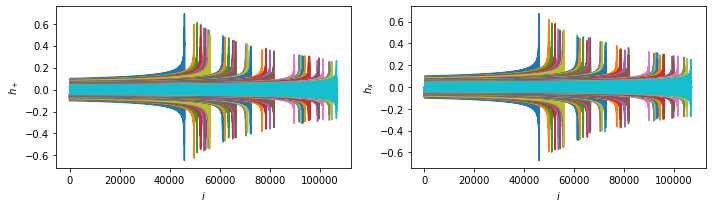

In [10]:
plt.subplot(1, 2, 1)
[plt.plot(hp_ro_pycbc[i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$i$')
plt.ylabel('$h_+$')

plt.subplot(1, 2, 2)
[plt.plot(hc_ro_pycbc[i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$i$')
plt.ylabel('$h_x$')

plt.tight_layout()
plt.show()

Zero-padding waveforms to create a common time grid. For each polarization the output is a column-ordered matrix (each column is one waveform).

In [11]:
times, hp_co_0pad = common_time_grid(hp_ro_pycbc, dt=delta_t_init)
times, hc_co_0pad = common_time_grid(hc_ro_pycbc, dt=delta_t_init)

In [12]:
#no longer needed
del hp_ro_pycbc, hc_ro_pycbc

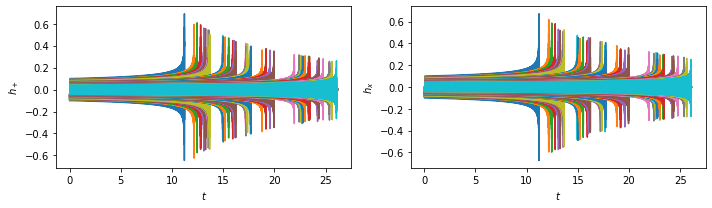

In [13]:
plt.subplot(1, 2, 1)
[plt.plot(times, hp_co_0pad[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$h_+$')

plt.subplot(1, 2, 2)
[plt.plot(times, hc_co_0pad[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$h_x$')

plt.tight_layout()
plt.show()

###Compute Amplitude.

In [14]:
A_co_0pad = np.sqrt(hp_co_0pad**2 + hc_co_0pad**2)


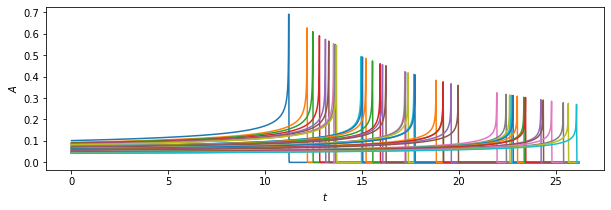

In [15]:
[plt.plot(times, A_co_0pad[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

###Compute Phase, then unwrap the phase of each waveform. 

In [16]:
phi_co_0pad = np.arctan2(-hc_co_0pad, hp_co_0pad)

In [17]:
del hc_co_0pad, hp_co_0pad

In [18]:
temp = phi_co_0pad[:,0]
phi_co_0pad_unwrap = np.unwrap(temp)

for i in range(1,lambda_values.shape[0]):
  temp = phi_co_0pad[:,i]
  temp_unwrap = np.unwrap(temp)
  phi_co_0pad_unwrap = (np.column_stack((phi_co_0pad_unwrap,temp_unwrap)))

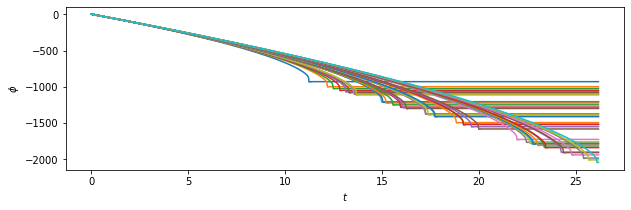

In [19]:
[plt.plot(times,phi_co_0pad_unwrap[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$\phi$')
plt.show()

In [20]:
display(phi_co_0pad_unwrap.shape, A_co_0pad.shape)

(107217, 40)

(107217, 40)

###Alignment



In [21]:
time_align, A_co_aligned, phi_co_aligned = align_A_phi(times, A_co_0pad, phi_co_0pad_unwrap, delta_t_init)
display(time_align)

[45920, 49810, 51016, 52411, 53684, 54377, 55409, 55736, 56003, 61244, 61507, 62215, 63630, 65253, 65742, 66447, 70461, 70604, 71161, 72387, 72586, 77054, 78561, 78563, 80233, 81744, 89894, 91867, 92614, 93001, 93324, 94231, 95631, 95974, 99211, 99725, 101476, 103955, 105012, 106753]


45920

In [22]:
del A_co_0pad, phi_co_0pad_unwrap

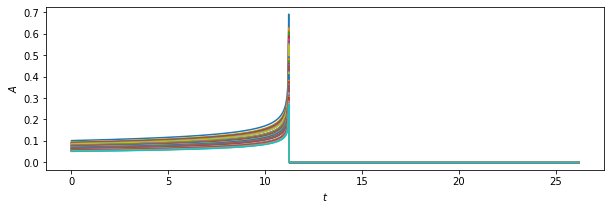

In [23]:
[plt.plot(times, A_co_aligned[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

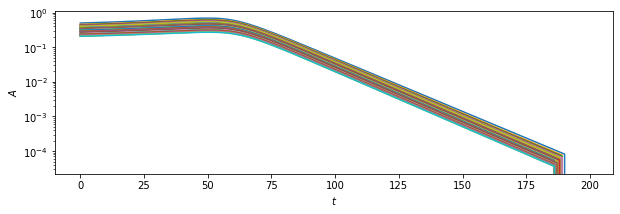

In [24]:
[plt.plot(A_co_aligned[time_align-50:time_align+150,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.yscale('log')
plt.show()

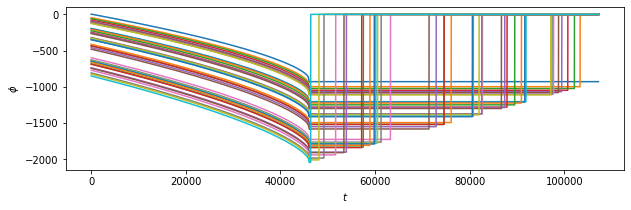

In [25]:
[plt.plot(phi_co_aligned[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$\phi$')
plt.show()

###Trim zeros that were added by zero padding from both $A$ and $\phi$ and restrict time to $-20,000M$ before alignment to $100M$ after alignment.




In [26]:
time_start = time_align - int(20000*Mtot*TIME/delta_t_init) 
time_trim = int(time_align + 100*Mtot*TIME/delta_t_init)
time_align_trim = time_align - time_start
time_end = int(time_align_trim + 100*Mtot*TIME/delta_t_init) # only inspiral part

display(time_start, time_trim, time_end, time_align_trim)

21703

46041

24338

24217

In [27]:
A_co_aligned_trim =  A_co_aligned[time_start:time_trim,]
phi_co_aligned_trim =  phi_co_aligned[time_start:time_trim,]
times_trim = times[time_start:time_trim]
times_trim = times_trim - times_trim[0]

In [28]:
del A_co_aligned, phi_co_aligned

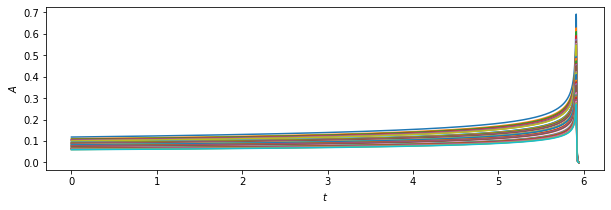

In [29]:
[plt.plot(times_trim, A_co_aligned_trim[:,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

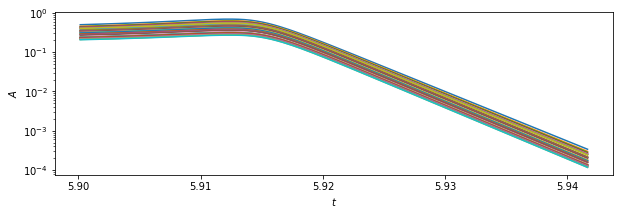

In [30]:
[plt.semilogy(times_trim[time_align_trim-50:time_align_trim+150],A_co_aligned_trim[time_align_trim-50:time_align_trim+150,i]) for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

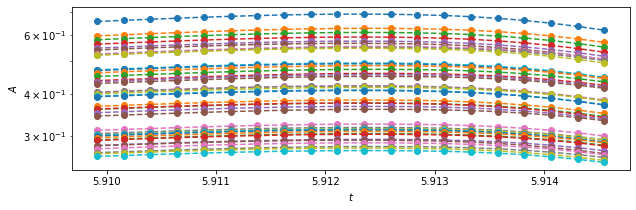

In [31]:
[plt.semilogy(times_trim[time_align_trim-10:time_align_trim+10],A_co_aligned_trim[time_align_trim-10:time_align_trim+10,i], 'o--') for i in range(lambda_values.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.show()

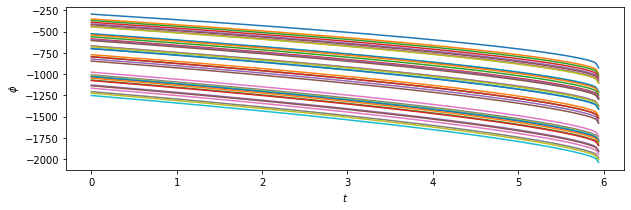

In [32]:
[plt.plot(times_trim, phi_co_aligned_trim[:,i]) for i in range(lambda_values.shape[0])];

plt.xlabel('$t$')
plt.ylabel('$\phi$')
plt.show()

###Shift phase vertically to common origin.

In [33]:
phi_co_aligned_trim_vshift = phi_co_aligned_trim[:,0] - phi_co_aligned_trim[0,0]

for i in range(1,lambda_values.shape[0]):
  temp = phi_co_aligned_trim[:,i] - phi_co_aligned_trim[0,i]
  phi_co_aligned_trim_vshift = (np.column_stack((phi_co_aligned_trim_vshift,temp)))

In [34]:
del phi_co_aligned_trim

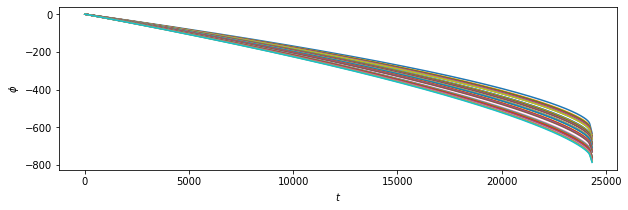

In [35]:
[plt.plot(phi_co_aligned_trim_vshift[:,i]) for i in range(lambda_values.shape[0])];

plt.xlabel('$t$')
plt.ylabel('$\phi$')
plt.show()

###ROM

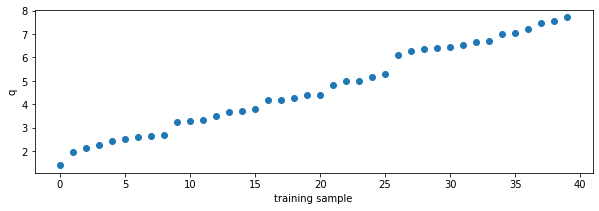

In [36]:
plt.plot(lambda_values,'o');
plt.xlabel('training sample')
plt.ylabel('q')
plt.show()

Transpose to store training data in row-ordered format (each row is one waveform).

In [37]:
A_ro = A_co_aligned_trim.transpose()
phi_ro = phi_co_aligned_trim_vshift.transpose()

In [38]:
del A_co_aligned_trim, phi_co_aligned_trim_vshift

Define an integration rule for the given training set (choices are riemmann, trapezoidal, chebychev or chebychev-lobatto). 

In [39]:
integration_A = rp.Integration([times_trim.min(), times_trim.max()], num=A_ro.shape[1], rule='trapezoidal')
integration_phi = rp.Integration([times_trim.min(), times_trim.max()], num=phi_ro.shape[1], rule='trapezoidal')

Construct the reduced basis, chosing a seed waveform and a maximum error.

>>> Warning(Index already selected): Exiting greedy algorithm.


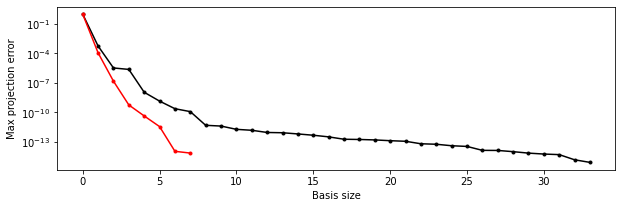

In [40]:
rb_A = rp.ReducedBasis(integration_A)
rb_A.make(A_ro, 0, 1e-16, verbose=False)

rb_phi = rp.ReducedBasis(integration_phi)
rb_phi.make(phi_ro, 0, 1e-16, verbose=False)

plt.semilogy(rb_A.errors/rb_A.errors[0], 'k.-');
plt.semilogy(rb_phi.errors/rb_phi.errors[0], 'r.-');
plt.xlabel('Basis size')
plt.ylabel('Max projection error')
plt.show()

Here we show which $q_i$ contribute in constructing the reduced basis.

In [41]:
display(rb_A.indices)

array([ 0, 39,  6,  5, 25, 19,  1, 10, 11,  2,  3,  7, 35,  4, 18, 12, 13,
       20,  8, 32, 24, 15,  9, 21, 23, 28, 14, 27, 37, 36, 34, 29, 33, 16],
      dtype=int32)

In [42]:
display(rb_phi.indices)

array([ 0, 39, 15,  5, 23, 28,  1,  7], dtype=int32)

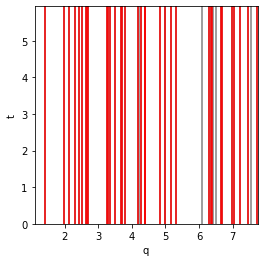

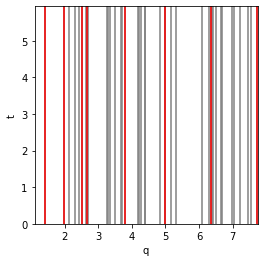

In [43]:
fig1 = plt.figure(1, [4,4])
ax2 = fig1.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in lambda_values]
[ax2.axvline(x=nn, color='red') for nn in lambda_values[rb_A.indices]]
ax2.set_ylim(0,max(times_trim))
ax2.set_xlabel('q');
ax2.set_ylabel('t');
plt.show()

fig2 = plt.figure(2, [4,4])
ax2 = fig2.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in lambda_values]
[ax2.axvline(x=nn, color='red') for nn in lambda_values[rb_phi.indices]]
ax2.set_ylim(0,max(times_trim))
ax2.set_xlabel('q');
ax2.set_ylabel('t');

plt.show()

The $i-$th (out of a total of $M$) waveform in the training set is well approximated by the expansion
$$
h(t ; q_i) \approx \sum_{j=1}^{m} c_{ij} e_{j}(t), \ \ \ i=1,\ldots,M, \ \ \ j=1,\ldots,m,
$$
where
$$
c_{ij} =\left\langle h(t ; q_i), e_{j}(t)\right\rangle,
$$
are the coefficients of the expansion, which are elements of an $M\times m$ matrix. With $<\  , \, > $ we denote the orthogonal projection. 

Below, we plot all basis functions $e_j(t)$. Notice that these are reported by rompy without normalization to unity.


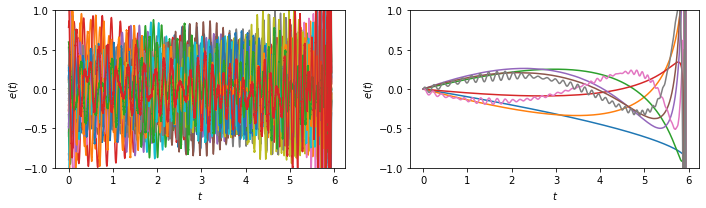

In [44]:
plt.subplot(1, 2, 1)
[plt.plot(times_trim, rb_A.basis[j]) for j in range(rb_A.size)];
plt.xlabel('$t$')
plt.ylabel('$e(t)$')
plt.ylim(-1, 1)

plt.subplot(1, 2, 2)
[plt.plot(times_trim, rb_phi.basis[j]) for j in range(rb_phi.size)];
plt.xlabel('$t$')
plt.ylabel('$e(t)$')
plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

The coefficients $c_{ij}$ are given by Rompy in transposed form as alpha[j][i] so we construct a new matrix in the right form.

In [45]:
display(rb_A.alpha.shape)

(34, 40)

In [46]:
rb_A_coeffs = rb_A.alpha.transpose()
rb_phi_coeffs = rb_phi.alpha.transpose()

For each basis function $e_j$ we can plot the coefficients $c_{ij}$ as a function of $q_i$. 

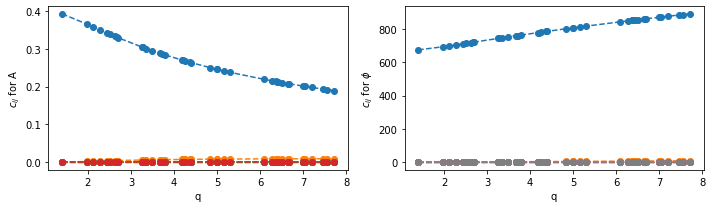

In [47]:
plt.subplot(1, 2, 1)
[plt.plot(lambda_values, rb_A_coeffs[:,j],'--o') for j in range(rb_A.size)];
plt.xlabel('q')
plt.ylabel('$c_{ij}$ for A')

plt.subplot(1, 2, 2)
[plt.plot(lambda_values, rb_phi_coeffs[:,j],'--o') for j in range(rb_phi.size)];
plt.xlabel('q')
plt.ylabel('$c_{ij}$ for $\phi$')

plt.tight_layout()
plt.show()

We can reconstruct each waveform $q_i$ by computing the expansion $\sum_{j=1}^{m} c_{ij} e_{j}(t)$ for $A$ and $\phi$. For example, for the waveform with $q=q_2$:

In [48]:
reconstructed_A = np.zeros(len(times_trim))
for j in range(rb_A.size):
  reconstructed_A += rb_A_coeffs[2,j]*rb_A.basis[j]

reconstructed_phi = np.zeros(len(times_trim))
for j in range(rb_phi.size):
  reconstructed_phi += rb_phi_coeffs[2,j]*rb_phi.basis[j]

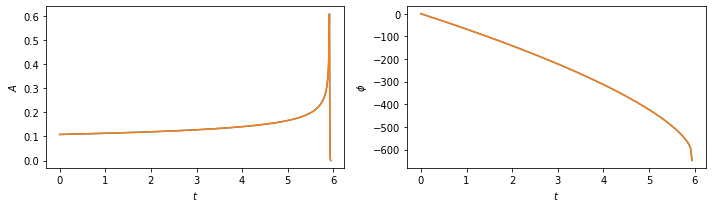

In [49]:
plt.subplot(1, 2, 1)
plt.plot(times_trim,reconstructed_A);
plt.plot(times_trim,A_ro[2]);
plt.xlabel('$t$')
plt.ylabel('$A$')

plt.subplot(1, 2, 2)
plt.plot(times_trim,reconstructed_phi);
plt.plot(times_trim,phi_ro[2]);
plt.xlabel('$t$')
plt.ylabel('$\phi$')

plt.tight_layout()
plt.show()


For each waveform, we can compute the overall mismatch with its reconstruction. The mismatch is practically zero for all the waveforms that correspond to the greedy points and at the requested error level of for the remaining waveforms in the training sample. Using a denser training sample reduces the mismatch for those remaining waveforms.

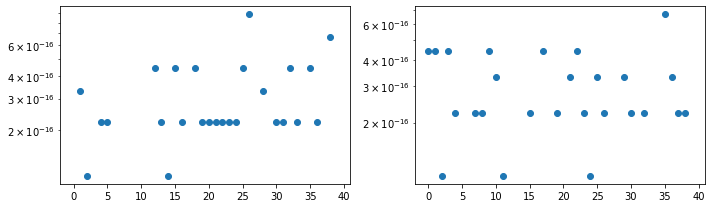

In [50]:
mismatch_A = [integration_A.mismatch(A_ro[i], rb_A.project(A_ro[i])) for i in range(lambda_values.shape[0])]
mismatch_phi = [integration_phi.mismatch(phi_ro[i], rb_phi.project(phi_ro[i])) for i in range(lambda_values.shape[0])]

plt.subplot(1, 2, 1)
plt.semilogy(np.abs(mismatch_A), 'o');

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(mismatch_phi), 'o');

plt.tight_layout()
plt.show()

###Generate a random validation set and evaluate the mismatch when projected onto the reduced-order basis.

In [51]:
nsample = 40
q_min = 1.0
q_max = 8.0
spin1z = 0.0
spin2z = 0.0
f_lower = 8.0
amplitude_scaling = 1e18

lambda_values_validation, hp_ro_pycbc_validation, hc_ro_pycbc_validation = training_set_generator(Mtot, nsample, \
                                                  q_min, q_max, spin1z, spin2z, f_lower, delta_t_init, \
                                                  amplitude_scaling, sampling = "random", verbose=True)

  2%|▎         | 1/40 [00:01<00:43,  1.11s/it]

length of h is 45192


  5%|▌         | 2/40 [00:02<00:41,  1.10s/it]

length of h is 45313


  8%|▊         | 3/40 [00:03<00:41,  1.12s/it]

length of h is 45593


 10%|█         | 4/40 [00:04<00:40,  1.12s/it]

length of h is 45982


 12%|█▎        | 5/40 [00:05<00:43,  1.24s/it]

length of h is 47782


 15%|█▌        | 6/40 [00:07<00:47,  1.38s/it]

length of h is 48051


 18%|█▊        | 7/40 [00:08<00:43,  1.31s/it]

length of h is 49457


 20%|██        | 8/40 [00:09<00:41,  1.28s/it]

length of h is 51469


 22%|██▎       | 9/40 [00:11<00:39,  1.26s/it]

length of h is 51959


 25%|██▌       | 10/40 [00:12<00:38,  1.27s/it]

length of h is 58779


 28%|██▊       | 11/40 [00:13<00:37,  1.29s/it]

length of h is 59863


 30%|███       | 12/40 [00:15<00:36,  1.30s/it]

length of h is 62048


 32%|███▎      | 13/40 [00:16<00:35,  1.31s/it]

length of h is 63188


 35%|███▌      | 14/40 [00:18<00:37,  1.43s/it]

length of h is 65624


 38%|███▊      | 15/40 [00:20<00:39,  1.58s/it]

length of h is 67617


 40%|████      | 16/40 [00:21<00:36,  1.53s/it]

length of h is 68548


 42%|████▎     | 17/40 [00:22<00:34,  1.51s/it]

length of h is 70412


 45%|████▌     | 18/40 [00:24<00:33,  1.51s/it]

length of h is 71848


 48%|████▊     | 19/40 [00:25<00:31,  1.50s/it]

length of h is 71963


 50%|█████     | 20/40 [00:27<00:29,  1.49s/it]

length of h is 72024


 52%|█████▎    | 21/40 [00:28<00:28,  1.51s/it]

length of h is 73546


 55%|█████▌    | 22/40 [00:31<00:29,  1.66s/it]

length of h is 74227


 57%|█████▊    | 23/40 [00:32<00:28,  1.70s/it]

length of h is 75272


 60%|██████    | 24/40 [00:34<00:27,  1.71s/it]

length of h is 75480


 62%|██████▎   | 25/40 [00:36<00:24,  1.66s/it]

length of h is 76947


 65%|██████▌   | 26/40 [00:37<00:22,  1.63s/it]

length of h is 77372


 68%|██████▊   | 27/40 [00:39<00:21,  1.62s/it]

length of h is 80087


 70%|███████   | 28/40 [00:40<00:19,  1.63s/it]

length of h is 83867


 72%|███████▎  | 29/40 [00:42<00:19,  1.77s/it]

length of h is 87162


 75%|███████▌  | 30/40 [00:45<00:18,  1.89s/it]

length of h is 90694


 78%|███████▊  | 31/40 [00:46<00:16,  1.87s/it]

length of h is 93368


 80%|████████  | 32/40 [00:48<00:14,  1.86s/it]

length of h is 93590


 82%|████████▎ | 33/40 [00:50<00:13,  1.86s/it]

length of h is 95889


 85%|████████▌ | 34/40 [00:52<00:11,  1.87s/it]

length of h is 97966


 88%|████████▊ | 35/40 [00:54<00:09,  1.96s/it]

length of h is 99302


 90%|█████████ | 36/40 [00:57<00:08,  2.11s/it]

length of h is 100033


 92%|█████████▎| 37/40 [00:59<00:06,  2.19s/it]

length of h is 101219


 95%|█████████▌| 38/40 [01:01<00:04,  2.13s/it]

length of h is 105068


 98%|█████████▊| 39/40 [01:03<00:02,  2.09s/it]

length of h is 105131


100%|██████████| 40/40 [01:05<00:00,  1.64s/it]

length of h is 109240


In [52]:
times_vd, hp_co_0pad_vd = common_time_grid(hp_ro_pycbc_validation, dt=delta_t_init)
times_vd, hc_co_0pad_vd = common_time_grid(hc_ro_pycbc_validation, dt=delta_t_init)

del hp_ro_pycbc_validation, hc_ro_pycbc_validation

A_co_0pad_vd = np.sqrt(hp_co_0pad_vd**2 + hc_co_0pad_vd**2)
phi_co_0pad_vd = np.arctan2(-hc_co_0pad_vd, hp_co_0pad_vd)

del hp_co_0pad_vd, hc_co_0pad_vd

temp = phi_co_0pad_vd[:,0]
phi_co_0pad_unwrap_vd = np.unwrap(temp)

for i in range(1,lambda_values_validation.shape[0]):
  temp = phi_co_0pad_vd[:,i]
  temp_unwrap = np.unwrap(temp)
  phi_co_0pad_unwrap_vd = (np.column_stack((phi_co_0pad_unwrap_vd,temp_unwrap)))

time_align_vd, A_co_aligned_vd, phi_co_aligned_vd = align_A_phi(times_vd, A_co_0pad_vd, phi_co_0pad_unwrap_vd, delta_t_init)
display(time_align_vd)

del A_co_0pad_vd, phi_co_0pad_vd, phi_co_0pad_unwrap_vd

time_start_vd = time_align_vd - int(20000*Mtot*TIME/delta_t_init) 
time_trim_vd = int(time_align_vd + 100*Mtot*TIME/delta_t_init)
time_align_trim_vd = time_align_vd - time_start_vd
time_end_vd = int(time_align_trim_vd + 100*Mtot*TIME/delta_t_init)

A_co_aligned_trim_vd =  A_co_aligned_vd[time_start_vd:time_trim_vd,]
phi_co_aligned_trim_vd =  phi_co_aligned_vd[time_start_vd:time_trim_vd,]
times_trim_vd = times[time_start_vd:time_trim_vd]
times_trim_vd = times_trim_vd - times_trim_vd[0]

del A_co_aligned_vd, phi_co_aligned_vd

phi_co_aligned_trim_vshift_vd = phi_co_aligned_trim_vd[:,0] - phi_co_aligned_trim_vd[0,0]

for i in range(1,lambda_values_validation.shape[0]):
  temp = phi_co_aligned_trim_vd[:,i] - phi_co_aligned_trim_vd[0,i]
  phi_co_aligned_trim_vshift_vd = (np.column_stack((phi_co_aligned_trim_vshift_vd,temp)))

del phi_co_aligned_trim_vd

A_ro_vd = A_co_aligned_trim_vd.transpose()
phi_ro_vd = phi_co_aligned_trim_vshift_vd.transpose()

del A_co_aligned_trim_vd, phi_co_aligned_trim_vshift_vd 

#A_ro_vd = A_ro_vd/A_ro_vd[0]  #scale amplitude by first waveform


[44722, 44842, 45123, 45512, 47313, 47581, 48988, 51000, 51490, 58311, 59396, 61581, 62721, 65157, 67150, 68082, 69946, 71382, 71497, 71558, 73080, 73762, 74806, 75014, 76482, 76906, 79622, 83402, 86697, 90229, 92903, 93125, 95425, 97501, 98837, 99569, 100755, 104604, 104667, 108776]


44722

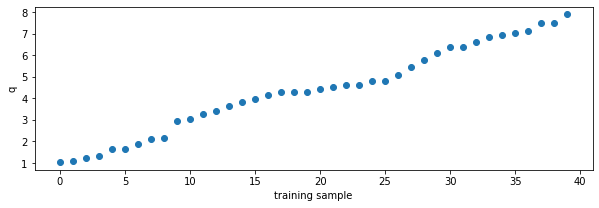

In [53]:
plt.plot(lambda_values_validation,'o');
plt.xlabel('training sample')
plt.ylabel('q')
plt.show()

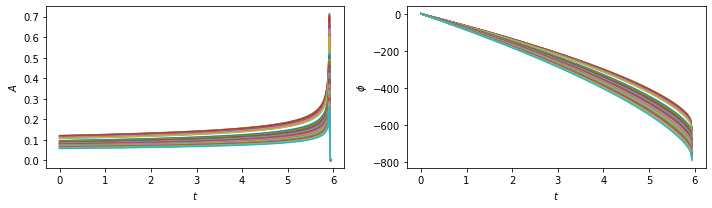

In [54]:
plt.subplot(1, 2, 1)
[plt.plot(times_trim_vd, A_ro_vd[i]) for i in range(lambda_values_validation.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$A$')

plt.subplot(1, 2, 2)
[plt.plot(times_trim_vd,phi_ro_vd[i]) for i in range(lambda_values_validation.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$\phi$')

plt.tight_layout()
plt.show()

In [55]:
display(len(times_trim_vd), len(times_trim))
diff_len = len(times_trim_vd) - len(times_trim)

24338

24338

In [56]:
A_ro_vd_trim = np.delete(A_ro_vd, np.s_[0:diff_len:1], 1)
phi_ro_vd_trim_tmp = np.delete(phi_ro_vd, np.s_[0:diff_len:1], 1)

phi_co_vd_trim = phi_ro_vd_trim_tmp.transpose()

phi_co_vd_trim_vshift = phi_co_vd_trim[:,0] - phi_co_vd_trim[0,0]

for i in range(1,lambda_values_validation.shape[0]):
  temp = phi_co_vd_trim[:,i] - phi_co_vd_trim[0,i]
  phi_co_vd_trim_vshift = (np.column_stack((phi_co_vd_trim_vshift,temp)))

phi_ro_vd_trim = phi_co_vd_trim_vshift.transpose()

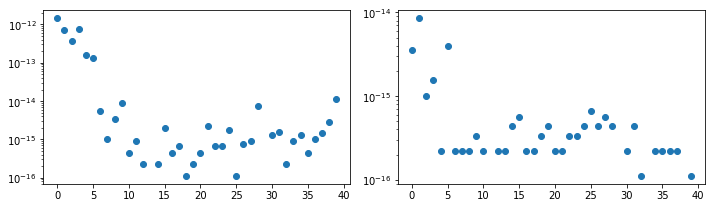

In [57]:
mismatch_A_vd = [integration_A.mismatch(A_ro_vd_trim[i], rb_A.project(A_ro_vd_trim[i])) \
                                               for i in range(lambda_values_validation.shape[0])]

mismatch_phi_vd = [integration_phi.mismatch(phi_ro_vd_trim[i], rb_phi.project(phi_ro_vd_trim[i])) \
                                               for i in range(lambda_values_validation.shape[0])]
plt.subplot(1, 2, 1)
plt.semilogy(np.abs(mismatch_A_vd), 'o');

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(mismatch_phi_vd), 'o');

plt.tight_layout()
plt.show()

###Empirical interpolation

Given the reduced-order basis, we compute the empirical interpolation nodes $T_k$ ($k=1,\ldots,m$) for $A$ and for $\phi$

In [58]:
eim_A = rp.EmpiricalInterpolant(rb_A.basis, verbose=True)
eim_phi = rp.EmpiricalInterpolant(rb_phi.basis, verbose=True)

('\nStep', '\t', 'Nodes')
(1, '\t', 24217)
(2, '\t', 23494)
(3, '\t', 24232)
(4, '\t', 24248)
(5, '\t', 24150)
(6, '\t', 24224)
(7, '\t', 24202)
(8, '\t', 1625)
(9, '\t', 24212)
(10, '\t', 24218)
(11, '\t', 24216)
(12, '\t', 24051)
(13, '\t', 24266)
(14, '\t', 24189)
(15, '\t', 8032)
(16, '\t', 24220)
(17, '\t', 24215)
(18, '\t', 179)
(19, '\t', 4503)
(20, '\t', 5518)
(21, '\t', 15639)
(22, '\t', 22965)
(23, '\t', 8993)
(24, '\t', 11294)
(25, '\t', 17296)
(26, '\t', 12144)
(27, '\t', 23920)
(28, '\t', 19604)
(29, '\t', 2666)
(30, '\t', 20460)
(31, '\t', 17698)
(32, '\t', 0)
(33, '\t', 6439)
(34, '\t', 24214)
('\nStep', '\t', 'Nodes')
(1, '\t', 24337)
(2, '\t', 22611)
(3, '\t', 24190)
(4, '\t', 24239)
(5, '\t', 15283)
(6, '\t', 24094)
(7, '\t', 24216)
(8, '\t', 24209)


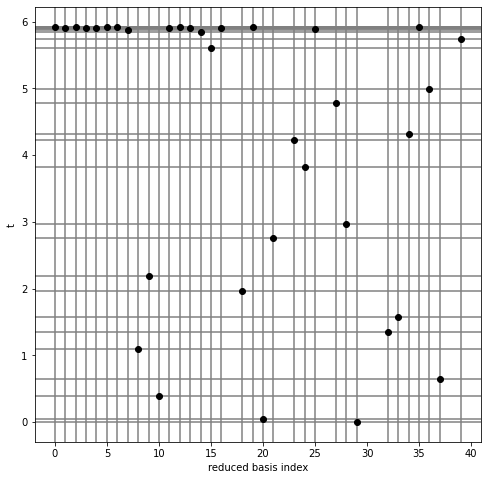

In [59]:
fig2 = plt.figure(2, [8,8])
ax2 = fig2.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in rb_A.indices]
[ax2.axhline(y=xx, color='gray') for xx in times_trim[eim_A.indices]]
ax2.plot(rb_A.indices, times_trim[eim_A.indices], 'ko');
ax2.set_xlabel('reduced basis index');
ax2.set_ylabel('t');
plt.show()

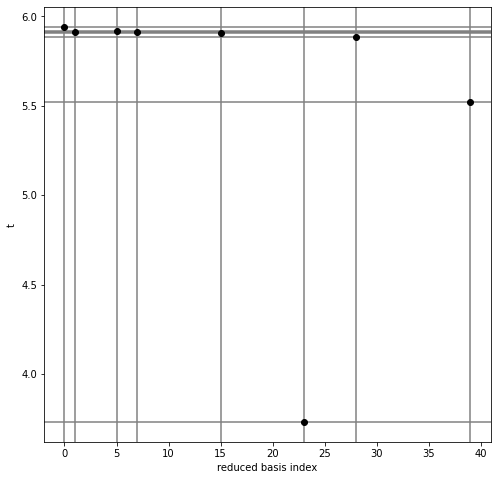

In [60]:
fig2 = plt.figure(2, [8,8])
ax2 = fig2.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in rb_phi.indices]
[ax2.axhline(y=xx, color='gray') for xx in times_trim[eim_phi.indices]]
ax2.plot(rb_phi.indices, times_trim[eim_phi.indices], 'ko');
ax2.set_xlabel('reduced basis index');
ax2.set_ylabel('t');
plt.show()

The waveforms in the training set can be reconstructed using the EIM basis. For example, for the 6th waveform:

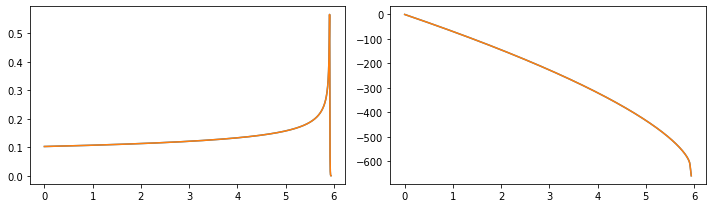

In [61]:
plt.subplot(1, 2, 1)
plt.plot(times_trim, A_ro[5], label='first')
plt.plot(times_trim, eim_A.interpolate(A_ro[5]), label='last')

plt.subplot(1, 2, 2)
plt.plot(times_trim, phi_ro[5], label='first')
plt.plot(times_trim, eim_phi.interpolate(phi_ro[5]), label='last')

plt.tight_layout()
plt.show() 

We can compute the mismatch between the original training set and the reconstructed through the EIM basis.

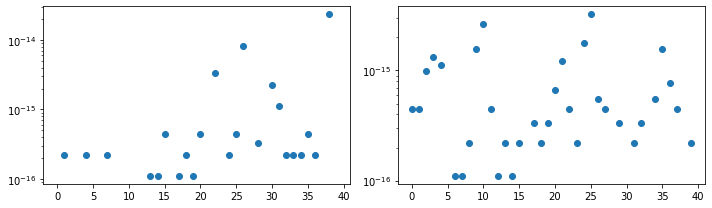

In [62]:
plt.subplot(1, 2, 1)
plt.semilogy(np.abs([integration_A.mismatch(A_ro[ii], eim_A.interpolate(A_ro[ii])) \
                                               for ii in range(lambda_values.shape[0])]), 'o');
                                              
plt.subplot(1, 2, 2)
plt.semilogy(np.abs([integration_phi.mismatch(phi_ro[ii], eim_phi.interpolate(phi_ro[ii])) \
                                               for ii in range(lambda_values.shape[0])]), 'o');
plt.tight_layout()
plt.show()                              

Compute mismatch for validation set.

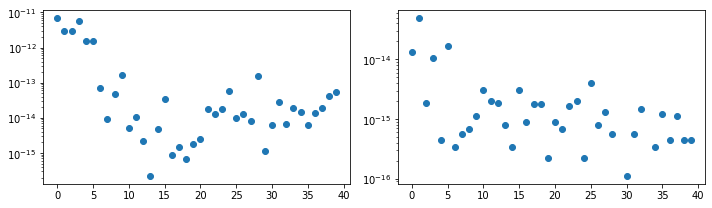

In [63]:
plt.subplot(1, 2, 1)
plt.semilogy(np.abs([integration_A.mismatch(A_ro_vd_trim[ii], eim_A.interpolate(A_ro_vd_trim[ii])) \
                                               for ii in range(lambda_values_validation.shape[0])]), 'o');
                                              
plt.subplot(1, 2, 2)
plt.semilogy(np.abs([integration_phi.mismatch(phi_ro_vd_trim[ii], eim_phi.interpolate(phi_ro_vd_trim[ii])) \
                                               for ii in range(lambda_values_validation.shape[0])]), 'o');
plt.tight_layout()
plt.show()  

### Construct EIM coefficient matrix

In order to construct the coefficient matrix of the EIM expansion, we first need to sort the indices of the reduced basis and the indices of the EIM time nodes in ascending order.

In [64]:
rb_A_indices_sorted = np.sort(rb_A.indices)
display(rb_A_indices_sorted)

eim_A_indices_sorted = np.sort(eim_A.indices)
display(eim_A_indices_sorted)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 32, 33, 34, 35, 36, 37, 39],
      dtype=int32)

array([    0,   179,  1625,  2666,  4503,  5518,  6439,  8032,  8993,
       11294, 12144, 15639, 17296, 17698, 19604, 20460, 22965, 23494,
       23920, 24051, 24150, 24189, 24202, 24212, 24214, 24215, 24216,
       24217, 24218, 24220, 24224, 24232, 24248, 24266], dtype=int32)

In [65]:
rb_phi_indices_sorted = np.sort(rb_phi.indices)
display(rb_phi_indices_sorted)

eim_phi_indices_sorted = np.sort(eim_phi.indices)
display(eim_phi_indices_sorted)

array([ 0,  1,  5,  7, 15, 23, 28, 39], dtype=int32)

array([15283, 22611, 24094, 24190, 24209, 24216, 24239, 24337],
      dtype=int32)

Now we can construct the matrix of coefficients $a_{ik}= h(T_k;Q_i)$.

First, construct a matrix, where each row is one of the waveforms in the training set that corresponds to a greedy point.

In [66]:
A_ro_greedy = A_ro[rb_A_indices_sorted,:]
phi_ro_greedy = phi_ro[rb_phi_indices_sorted,:]


In [67]:
display(A_ro_greedy.shape)
display(phi_ro_greedy.shape)

(34, 24338)

(8, 24338)

Next, select the subset of this matrix, that is evaluated only at the empirical time nodes $T_k$.

In [68]:
a_ik_A = A_ro_greedy[:,eim_A_indices_sorted]
a_ik_phi = phi_ro_greedy[:,eim_phi_indices_sorted]

In [69]:
display(a_ik_A.shape)
display(a_ik_phi.shape)

(34, 34)

(8, 8)

Selecting specific columns (i.e. specific times $T_k$) we obtain 1-D lists $\alpha_k$ that depend on $Q_i$. These can then be fitted to produce interpolating functions $\hat \alpha_k$. For all waveforms in the training set:

In [70]:
a_ik_A_all = A_ro[:,eim_A_indices_sorted]
a_ik_phi_all = phi_ro[:,eim_phi_indices_sorted]

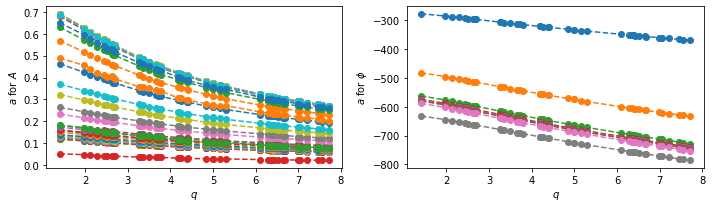

In [71]:
plt.subplot(1, 2, 1)
[plt.plot(lambda_values, a_ik_A_all[:,k], '--o') for k in range(eim_A.indices.shape[0])];
plt.xlabel('$q$')
plt.ylabel('$a$ for $A$')

plt.subplot(1, 2, 2)
[plt.plot(lambda_values, a_ik_phi_all[:,k],  '--o') for k in range(eim_phi.indices.shape[0])];
plt.xlabel('$q$')
plt.ylabel('$a$ for $\phi$')

plt.tight_layout()
plt.show() 

###Construct the EIM basis $B_k(t)$.

First, find the order in which the ROM basis functions were selected, then re-order the basis functions, so that they correspond to ascending order in $q$.

In [72]:
rb_A_sorted_order =np.argsort(rb_A.indices) 
rb_phi_sorted_order =np.argsort(rb_phi.indices) 

In [73]:
rb_A_basis_sorted = rb_A.basis[rb_A_sorted_order]
rb_phi_basis_sorted = rb_phi.basis[rb_phi_sorted_order]


Construct a matrix, where each row is one of the basis functions $e_j$ of the ROM basis.

In [74]:
ej_A_basis_ro = []
for basis in rb_A_basis_sorted:
  ej_A_basis_ro.append(basis)

ej_A_basis_ro=np.asarray(ej_A_basis_ro)

ej_phi_basis_ro = []
for basis in rb_phi_basis_sorted:
  ej_phi_basis_ro.append(basis)

ej_phi_basis_ro=np.asarray(ej_phi_basis_ro)

Next, select the subset of this matrix, that is evaluated only at the empirical time nodes $T_k$.

In [75]:
Vkj_A_ro = ej_A_basis_ro[:,eim_A_indices_sorted]
Vkj_phi_ro = ej_phi_basis_ro[:,eim_phi_indices_sorted]

Compute the inverse matrix.

In [76]:
Vkj_A_ro_INV = np.linalg.inv(Vkj_A_ro)
Vkj_phi_ro_INV = np.linalg.inv(Vkj_phi_ro)

Compute the EIM basis functions $B_k(t)$ (each row is one basis function).

In [77]:
eim_A_basis = Vkj_A_ro_INV.dot(rb_A_basis_sorted)
eim_phi_basis = Vkj_phi_ro_INV.dot(rb_phi_basis_sorted)

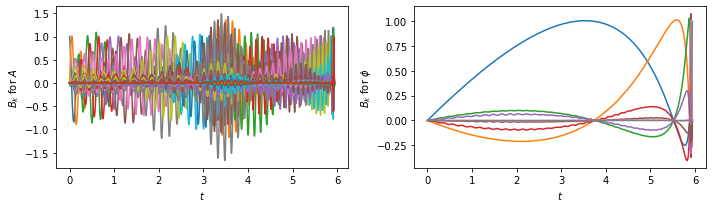

In [78]:
plt.subplot(1, 2, 1)
[plt.plot(times_trim, eim_A_basis[k]) for k in range(eim_A.indices.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$B_k$ for $A$')

plt.subplot(1, 2, 2)
[plt.plot(times_trim, eim_phi_basis[k]) for k in range(eim_phi.indices.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$B_k$ for $\phi$')

plt.tight_layout()
plt.show()

###Reconstruct the waveforms in the training set, using the EIM basis.

In [79]:
A_reconstruct =a_ik_A_all.dot(eim_A_basis)
phi_reconstruct =a_ik_phi_all.dot(eim_phi_basis)

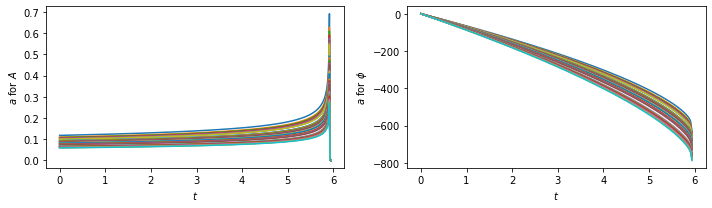

In [80]:
plt.subplot(1, 2, 1)
[plt.plot(times_trim, A_reconstruct[k]) for k in range(A_reconstruct.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$a$ for $A$')

plt.subplot(1, 2, 2)
[plt.plot(times_trim, phi_reconstruct[k]) for k in range(phi_reconstruct.shape[0])];
plt.xlabel('$t$')
plt.ylabel('$a$ for $\phi$')


plt.tight_layout()
plt.show()

Mismatch for all waveforms (we basically obtain the same results as with Rompy's *interpolate* routine).

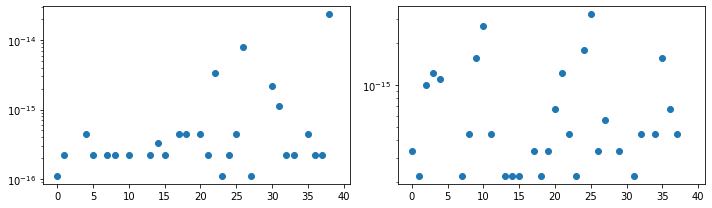

In [81]:
mismatch_A_eim = [integration_A.mismatch(A_ro[i], A_reconstruct[i]) for i in range(A_reconstruct.shape[0])]
mismatch_phi_eim = [integration_phi.mismatch(phi_ro[i], phi_reconstruct[i]) for i in range(phi_reconstruct.shape[0])]

plt.subplot(1, 2, 1)
plt.semilogy(np.abs(mismatch_A_eim), 'o');

plt.subplot(1, 2, 2)
plt.semilogy(np.abs(mismatch_phi_eim), 'o');

plt.tight_layout()
plt.show()

Reconstructing the original waveforms:

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


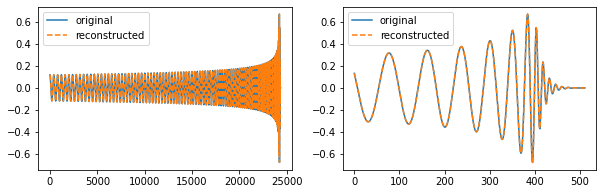

In [82]:
w_ro = A_ro * np.exp(1j * phi_ro)
w_reconstruct = A_reconstruct * np.exp(1j * phi_reconstruct)

plt.subplot(1, 2, 1)
plt.plot(w_ro[0], label='original')
plt.plot(w_reconstruct[0], '--', label='reconstructed')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(w_ro[0][-512:], label='original')
plt.plot(w_reconstruct[0][-512:], '--', label='reconstructed')
plt.legend()

###Timings

In [83]:
m1, m2 = Mq_to_m1m2(60.0, lambda_values[0])
chi1 = 0
chi2 = 0
delta_t = delta_t=delta_t_init
%timeit -n3 -r3 hp, hc = get_td_waveform(approximant='SEOBNRv4', mass1=m1, mass2=m2, \
                                         spin1z=chi1, spin2z=chi2, \
                                         delta_t=delta_t, \
                                         f_lower=8.0, \
                                         mode_array=[[2, 2]])

%timeit -n3 -r3 eim_A.interpolate(A_ro[0])

1.23 s ± 130 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
245 µs ± 111 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [84]:
display(times_trim.size, lambda_values.shape[0], eim_A.size, rb_A.size )
print(float(times_trim.size*lambda_values.shape[0])/(eim_A.size*rb_A.size))


24338

40

34

34

842.1453287197232
